In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [2]:
import dipy.reconst.dti as dti
import dipy.reconst.dki as dki
import dipy.reconst.cross_validation as xval
import dipy.core.gradients as dpg
from dipy.segment.mask import median_otsu

In [3]:
import nibabel as nib

In [4]:
import tools
import imp
imp.reload(tools)
from tools import resample_volume

In [ ]:
# Replace with a loop over subjects:
subject = '991267'

In [5]:
dwi_img = nib.load('/home/ubuntu/data/%s/sess/dwi/dwi.nii.gz'%subject)
gtab = dpg.gradient_table('/home/ubuntu/data/%s/sess/dwi/dwi.bvals'%subject, 
                          '/home/ubuntu/data/%s/sess/dwi/dwi.bvecs'%subject,
                          b0_threshold=10)

In [6]:
data = dwi_img.get_data()

In [7]:
label_img = nib.load('/home/ubuntu/data/%s/sess/anat/aparc+aseg.nii.gz'%subject)

resamp_label = resample_volume(label_img, dwi_img)

label_data = resamp_label.get_data()

# Cerebral white matter in both hemispheres + corpus callosum
wm_mask = (label_data==41) | (label_data==2) | (label_data==86)

In [14]:
dki_model = dki.DiffusionKurtosisModel(gtab)
dti_model = dti.TensorModel(gtab)

In [15]:
def calc_cod(model, data, mask=None, folds=5):
    pred = xval.kfold_xval(model, data, folds, mask=mask)
    cod = xval.coeff_of_determination(pred, data)
    return cod

In [16]:
cod_dki = calc_cod(dki_model, data) 
cod_dti = calc_cod(dti_model, data)

/home/ubuntu/source/dipy/dipy/reconst/cross_validation.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return 100 * (1 - (ss_err/ss_tot))
/home/ubuntu/source/dipy/dipy/reconst/cross_validation.py:57: RuntimeWarning: invalid value encountered in true_divide
  return 100 * (1 - (ss_err/ss_tot))


In [ ]:
nib.save(nib.Nifti1Image(cod_dki, dwi_img.affine), 'COD_dki_%s.nii.gz'%subject)
nib.save(nib.Nifti1Image(cod_dki, dwi_img.affine), 'COD_dti_%s.nii.gz'%subject)

(50, 100)

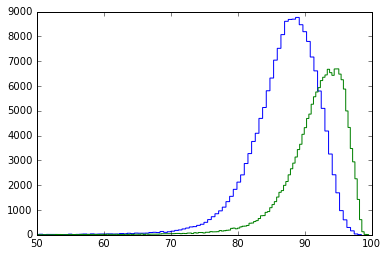

In [17]:
plt.hist(cod_dti[np.isfinite(cod_dki)], bins=1000, histtype='step')
plt.hist(cod_dki[np.isfinite(cod_dki)], bins=1000, histtype='step')
plt.xlim([50,100])

(-15, 15)

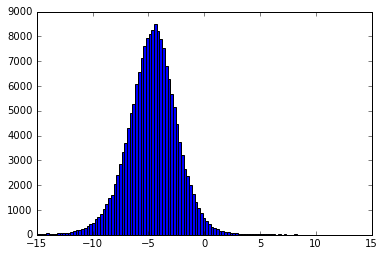

In [18]:
plt.hist(cod_dti[np.isfinite(cod_dki)] - cod_dki[np.isfinite(cod_dki)], bins=1000)
plt.xlim([-15, 15])

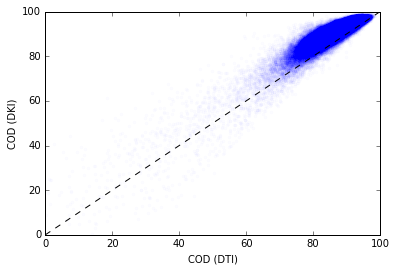

In [19]:
plt.plot(cod_dti[np.isfinite(cod_dki)], cod_dki[np.isfinite(cod_dki)], '.', alpha=0.01)
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.plot([0, 100], [0, 100], 'k--')
plt.xlabel("COD (DTI)")
plt.ylabel("COD (DKI)")

In [20]:
dki_fit = dki_model.fit(data, mask=wm_mask)
dti_fit = dti_model.fit(data, mask=wm_mask)

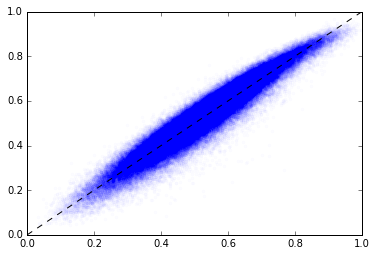

In [22]:
plt.plot(dki_fit.fa[wm_mask], dti_fit.fa[wm_mask], '.', alpha=0.01)
plt.plot([0, 1], [0, 1], 'k--')

In [23]:
np.corrcoef(dki_fit.fa[wm_mask], dti_fit.fa[wm_mask])

array([[ 1.        ,  0.95582013],
       [ 0.95582013,  1.        ]])

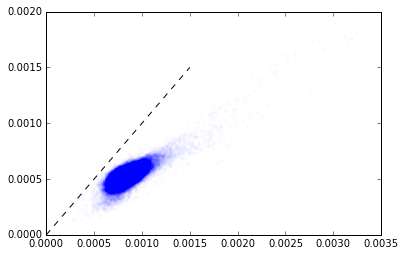

In [24]:
plt.plot(dki_fit.md[wm_mask], dti_fit.md[wm_mask], '.', alpha=0.01)
plt.plot([0, 0.0015], [0, 0.0015], 'k--')

In [26]:
idx1000 = (gtab.bvals < 1100) | (gtab.bvals <= 5)
idx2000 = ((gtab.bvals > 1100) & (gtab.bvals < 2100 )) | (gtab.bvals <= 5)
idx3000 = (gtab.bvals > 2100) | (gtab.bvals <= 5)

In [27]:
data1000 = data[..., idx1000]
data2000 = data[..., idx2000]
data3000 = data[..., idx3000]
data1000_2000 = data[..., idx1000 + idx2000]
data1000_3000 = data[..., idx1000 + idx3000]
data2000_3000 = data[..., idx2000 + idx3000]

In [28]:
gtab1000 = dpg.gradient_table(gtab.bvals[idx1000], gtab.bvecs[idx1000], b0_threshold=5)
gtab2000 = dpg.gradient_table(gtab.bvals[idx1000], gtab.bvecs[idx1000], b0_threshold=5)
gtab3000 = dpg.gradient_table(gtab.bvals[idx1000], gtab.bvecs[idx1000], b0_threshold=5)
gtab1000_2000 = dpg.gradient_table(gtab.bvals[idx1000 + idx2000], gtab.bvecs[idx1000 + idx2000], b0_threshold=5)
gtab1000_3000 = dpg.gradient_table(gtab.bvals[idx1000 + idx3000], gtab.bvecs[idx1000 + idx3000], b0_threshold=5)
gtab2000_3000 = dpg.gradient_table(gtab.bvals[idx2000 + idx3000], gtab.bvecs[idx2000 + idx3000], b0_threshold=5)

In [29]:
dti_model1000 = dti.TensorModel(gtab1000)
dti_model2000 = dti.TensorModel(gtab2000)
dti_model3000 = dti.TensorModel(gtab3000)
dti_model1000_2000 = dti.TensorModel(gtab1000_2000)
dti_model1000_3000 = dti.TensorModel(gtab1000_3000)
dti_model2000_3000 = dti.TensorModel(gtab2000_3000)

In [30]:
dti_fit1000 = dti_model1000.fit(data1000, mask=wm_mask)
dti_fit2000 = dti_model2000.fit(data2000, mask=wm_mask)
dti_fit3000 = dti_model3000.fit(data3000, mask=wm_mask)
dti_fit1000_2000 = dti_model1000_2000.fit(data1000_2000, mask=wm_mask)
dti_fit1000_3000 = dti_model1000_3000.fit(data1000_3000, mask=wm_mask)
dti_fit2000_3000 = dti_model2000_3000.fit(data2000_3000, mask=wm_mask)

In [31]:
np.corrcoef(dti_fit1000.md[wm_mask], dti_fit3000.md[wm_mask])

array([[ 1.        ,  0.68006152],
       [ 0.68006152,  1.        ]])

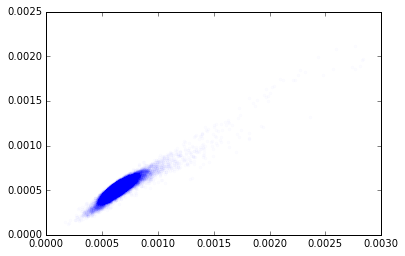

In [32]:
plt.plot(dti_fit1000_2000.md[wm_mask], dti_fit1000_3000.md[wm_mask], '.', alpha=0.01)

In [33]:
dki_model1000_2000 = dki.DiffusionKurtosisModel(gtab1000_2000)
dki_model1000_3000 = dki.DiffusionKurtosisModel(gtab1000_3000)
dki_model2000_3000 = dki.DiffusionKurtosisModel(gtab2000_3000)

In [34]:
dki_fit1000_2000 = dki_model1000_2000.fit(data1000_2000, mask=wm_mask)
dki_fit1000_3000 = dki_model1000_3000.fit(data1000_3000, mask=wm_mask)
dki_fit2000_3000 = dki_model2000_3000.fit(data2000_3000, mask=wm_mask)

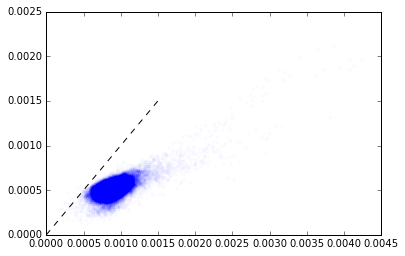

In [35]:
plt.plot(dki_fit1000_3000.md[wm_mask], dti_fit1000_3000.md[wm_mask], '.', alpha=0.01 )
plt.plot([0, 0.0015], [0, 0.0015], 'k--')

In [36]:
np.corrcoef(dki_fit1000_2000.fa[wm_mask], dki_fit1000_3000.fa[wm_mask])

array([[ 1.        ,  0.99007793],
       [ 0.99007793,  1.        ]])

In [37]:
np.corrcoef(dki_fit1000_2000.md[wm_mask], dki_fit1000_3000.md[wm_mask])

array([[ 1.        ,  0.99275055],
       [ 0.99275055,  1.        ]])

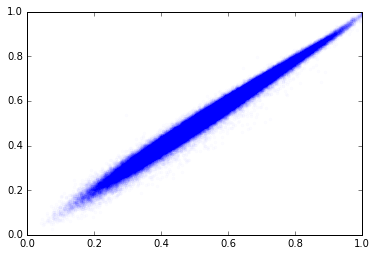

In [38]:
plt.plot(dki_fit1000_2000.fa[wm_mask], dki_fit1000_3000.fa[wm_mask], '.', alpha=0.01)

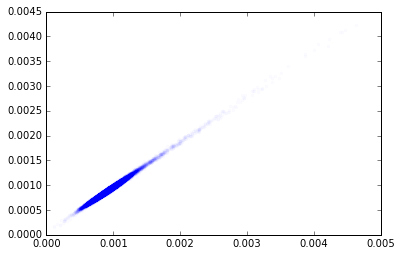

In [39]:
plt.plot(dki_fit1000_2000.md[wm_mask], dki_fit1000_3000.md[wm_mask], '.', alpha=0.01)

In [40]:
mean_b0 = np.mean(data[..., gtab.b0s_mask], -1)

In [41]:
mean_b0.shape

(145, 174, 145)

In [49]:
dti_predict_1k_from2k = dti_fit2000.predict(gtab1000)

/home/ubuntu/source/dipy/dipy/reconst/dti.py:1786: RuntimeWarning: divide by zero encountered in log
  D[..., 6] = -np.log(b0)


In [57]:
cod = xval.coeff_of_determination(dti_predict_1k_from2k, data1000)

/home/ubuntu/source/dipy/dipy/reconst/cross_validation.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return 100 * (1 - (ss_err/ss_tot))
/home/ubuntu/source/dipy/dipy/reconst/cross_validation.py:57: RuntimeWarning: invalid value encountered in true_divide
  return 100 * (1 - (ss_err/ss_tot))


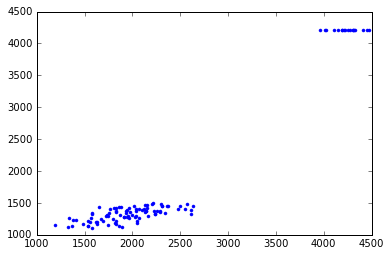

In [58]:
plt.plot(data1000[19, 84, 57], dti_predict_1k_from2k[19,  84, 57], '.')

In [59]:
mean_b0[19, 84, 57]

4233.1836